In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import itertools

import torch
from torch import nn

import youtokentome as yttm

from utils.base import get_params_number, init_random_seed, train_loop_GAN
from utils.poetry import *
from utils.transformer_tools import *

init_random_seed(1702)

In [2]:
horus = load_chunks("./datasets/TLotR_red.txt", chunk_size=300)

ALL_LEN = len(horus)
print(ALL_LEN)
len_for_steps = int(ALL_LEN / 3)
horus_for_GAN = horus[len_for_steps * 2:]
horus = horus[:len_for_steps * 2]
print(len(horus))
print(len(horus_for_GAN))

16825
11216
5609


In [4]:
BPE_MODEL_FILENAME = './models/tokens/lord_bpe_1000_new.yttm'

tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ e t a o n h s r i d l u w g m f y c , . b p ' k v I T B S A ! F H G W ; - M ` E ? : _ R N O L D Y P q C j x z " – U ) ( K V 1 Q J 9 4 3 2 0 7 6 8 5 Z * X = / ▁t he ▁a ▁the in ▁s ▁w nd re ▁o ▁h ou ▁b ▁f ▁and er ed ing at ll it ▁m ▁c ▁l ▁of is ar or en ▁d as ▁to ▁th ▁n es ro ▁he ▁g an id ▁in on ow ▁' ▁I ad ut ▁p ▁be ot ▁y ▁T gh om ld ▁e ▁it ▁st ▁sa ▁was ▁we ▁that ▁u ve ▁you le im ir ay ▁on ▁The ly ght ▁ha am et ▁B st ▁not ▁S ▁said ▁his ill oo se ▁as ▁they ver ▁r ur ▁for ▁A ▁F ac ith ▁is ee ▁G and ▁wh ▁sh al il ight ▁H ▁with ain all ard ▁re ,' ke ould .' ▁had ▁M ▁an ent her ▁at ic ore s, if ome ▁` ast ▁have ▁were ▁him s. red rod ▁but ▁E ▁up ▁W ag ind ▁them ong ▁k th rodo ▁le ▁Frodo rom ▁or ▁do ▁all e. e, ▁see ▁He ▁from nt pp ▁fe ood ch ▁ne ack ▁are ri ▁their ter 's ▁gre ▁sp ▁li ▁R ▁ho ▁there ▁no ▁go ▁now ▁su ▁ag ▁me ▁out ound ▁will ▁But orn ▁so ▁if ook !' ess um ord ry own ame ce ▁kn ▁al ▁O ▁whe ough out ▁long to ust ol ▁'I ▁L ell ark ▁my ▁ro ven ▁cl ▁ab ▁again ▁

In [ ]:
token_ids = tokenizer.encode(horus_for_GAN, bos=True, eos=True)

unknown_subwords_in_test = sum(1 for text in token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов', unknown_subwords_in_test)

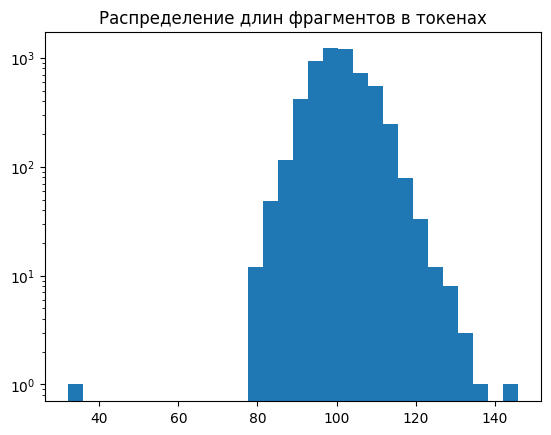

In [6]:
plt.hist([len(sent) for sent in token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log')

In [7]:
start_length = 20
end_length = 50

all_dataset = Dataset_for_GAN(token_ids, start_len=start_length, end_len=end_length)

In [8]:
check = all_dataset[2036]

print(check[0])
print(check[1])
print(tokenizer.decode(check[0].tolist()))
print(tokenizer.decode(check[1].tolist()))

[244  19 529 319 191 699 101 714 174 322 512 131 173  26 432  24 128 816
  24 220]
[811 144 470 162 390  87 584  99  84 166  87 897 348 108 681  10 122 381
  23 269 170 232 162 381 419 107 102 234 427 246 906 944  86  85 129  24
 135   8 880 540 144 410 271 667 194 164 496  24 667 365]
['nemy, challenging him, for this very purpose. I wonder. W']
["ell, we shall not know the answer till the Riders of Rohan come, if they do not come too late. There are evil days ahead. To sleep while we may!' 'But,' said Pippin. 'But what"]


In [9]:
D_model = LSTM_Discriminator(100, 256, tokenizer.vocab_size())
print('Количество параметров дискриминатора', get_params_number(D_model))

G_model = Language_Model(
    vocab_size = tokenizer.vocab_size(),
    embedding_size = 256,
    backbone = Transformer_Encoder(
        nn.TransformerEncoderLayer(
            d_model = 256,
            nhead = 16,
            dim_feedforward = 512,
            dropout = 0.1
        ),
        num_layers=5
    ),
    emb_dropout = 0.1
)
print('Количество параметров генератора', get_params_number(G_model))

Количество параметров дискриминатора 399301
Количество параметров генератора 3148520


In [11]:
optimizer_SD_G = torch.load('./models/Lord/4/Lord_opt.pth')
G_model.load_state_dict(torch.load('./models/Lord/4/Lord.pth'))

<All keys matched successfully>

In [12]:
batch_size = 64

model_D, model_G, optimizer_D, optimizer_G, loss_history_D, loss_history_G = train_loop_GAN(
    D_model,
    G_model,
    all_dataset,
    lm_b_cross_entropy,
    lr_D=1e-2,
    lr_G=1e-4,
    epoch_n=1000,
    batch_size=batch_size,
    device='cuda',
    # early_optimizer_SD_D=optimizer_SD_D,
    early_optimizer_SD_G=optimizer_SD_G,
    tokenizer=tokenizer,
    need_to_gen=True,
    end_chunk=end_length,
    pharse="For the king and "
)

Эпоха 0


88it [00:33,  2.61it/s]


Эпоха прошла за 33.7 секунд
Средняя функция потерь для дискриминатора = 0.3755197898823429
Средняя функция потерь для генератора = 3.5923347066749227
For the king and the fairest of the world, and the Silverlode flowed down into the Westfold-men, and the Silverlode fl
Следующая эпоха
Эпоха 1


88it [00:32,  2.71it/s]


Эпоха прошла за 32.48 секунд
Средняя функция потерь для дискриминатора = 0.10216304563536224
Средняя функция потерь для генератора = 5.540537080981514
For the king and the fields of the Enemy. One Ring passed over the Mountains, and the Dark Lord of the Mountains of Mordor, and the Mark,
Следующая эпоха
Эпоха 2


88it [00:32,  2.69it/s]


Эпоха прошла за 32.67 секунд
Средняя функция потерь для дискриминатора = 0.0533998224127572
Средняя функция потерь для генератора = 6.471644997596741
For the king and held up his hand. 'Gandalf!' he cried. 'Do you hear it?' he said. 'Ents!' said the Ridermen. 'This is the
Следующая эпоха
Эпоха 3


88it [00:32,  2.69it/s]


Эпоха прошла за 32.7 секунд
Средняя функция потерь для дискриминатора = 0.033481172981820156
Средняя функция потерь для генератора = 7.376548680392179
For the king and held a great horse, and the horsemen stood upon the horses, and the horses of the Emyn Muil. The horses were g
Следующая эпоха
Эпоха 4


88it [00:32,  2.70it/s]


Эпоха прошла за 32.64 секунд
Средняя функция потерь для дискриминатора = 0.037544114364374596
Средняя функция потерь для генератора = 7.89955461025238
For the king and the Darkness of the Mark Lordor, and the Mountains of the Mountains of Shadow; and the Shadows of the Windlords of the
Следующая эпоха
Эпоха 5


88it [00:32,  2.68it/s]


Эпоха прошла за 32.81 секунд
Средняя функция потерь для дискриминатора = 0.03228496944013221
Средняя функция потерь для генератора = 8.168828097256748
For the king and the familiar. Then he spoke to his companions. 'Ready! Come now!' he said. 'Farewell!' he said. 'This is
Следующая эпоха
Эпоха 6


88it [00:32,  2.71it/s]


Эпоха прошла за 32.42 секунд
Средняя функция потерь для дискриминатора = 0.016227496732343836
Средняя функция потерь для генератора = 8.803565632213246
For the king and his companions stood silent. He looked up, and he saw that he was sitting with an effort. He was sitting upon his knees, and his
Следующая эпоха
Эпоха 7


88it [00:33,  2.64it/s]


Эпоха прошла за 33.34 секунд
Средняя функция потерь для дискриминатора = 0.030604755177178464
Средняя функция потерь для генератора = 8.748872117562728
For the king and power of the world. And the Silverlode flows of the Silverlode flows into the Great River, and the Sea
Следующая эпоха
Эпоха 8


88it [00:32,  2.72it/s]


Эпоха прошла за 32.4 секунд
Средняя функция потерь для дискриминатора = 0.018974730124517173
Средняя функция потерь для генератора = 9.028596639633179
For the king and held up his hand. 'Good night!' he cried. 'Gandalf!' he cried. 'Gandalf!' he cried. 'Good-bye!' he
Следующая эпоха
Эпоха 9


88it [00:32,  2.72it/s]


Эпоха прошла за 32.35 секунд
Средняя функция потерь для дискриминатора = 0.016849978292818625
Средняя функция потерь для генератора = 9.67595187100497
For the king and the power of the Lord of Mark, and the Mark of Mordor. The Ring is drawing near the Redhorn Galadriel, and
Следующая эпоха
Эпоха 10


88it [00:32,  2.72it/s]


Эпоха прошла за 32.31 секунд
Средняя функция потерь для дискриминатора = 0.018156082010219423
Средняя функция потерь для генератора = 9.69728444923054
For the king and corner of the Sea. Only the Lady Galadriel speak of the Lady of Lothlorien, the Galadriel of the
Следующая эпоха
Эпоха 11


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.014770974689202954
Средняя функция потерь для генератора = 10.12381602417339
For the king and the Lady Galadriel refindel, and the Golden Windel is now refrenown in the Emyn Muil, and the
Следующая эпоха
Эпоха 12


88it [00:32,  2.71it/s]


Эпоха прошла за 32.48 секунд
Средняя функция потерь для дискриминатора = 0.013297808834481244
Средняя функция потерь для генератора = 9.992048978805542
For the king and his men of Rohan. Helm's Deeping the Gate. Helm's Gate is the Westfold, and the Wind of the Westf
Следующая эпоха
Эпоха 13


88it [00:32,  2.72it/s]


Эпоха прошла за 32.35 секунд
Средняя функция потерь для дискриминатора = 0.015001414128412514
Средняя функция потерь для генератора = 10.205712047490207
For the king and corner of the Dwarves. One Ring-bearer! One Ring! One Ring-bearer! O! One Ring! O! O Elbe
Следующая эпоха
Эпоха 14


88it [00:32,  2.70it/s]


Эпоха прошла за 32.59 секунд
Средняя функция потерь для дискриминатора = 0.011580926622462523
Средняя функция потерь для генератора = 10.310669736428695
For the king and the men of the Westfold, and the Dwarf-master of the Dark Lord of the Mountains of the Mark Tirith. For the Elves of
Следующая эпоха
Эпоха 15


88it [00:32,  2.71it/s]


Эпоха прошла за 32.51 секунд
Средняя функция потерь для дискриминатора = 0.02095319534088379
Средняя функция потерь для генератора = 11.094632463021712
For the king and the White Mountains of the Dark Lord and the Mountains and the Mountains of Mordor, and the Mountains of Minas Tirith.
Следующая эпоха
Эпоха 16


88it [00:32,  2.70it/s]


Эпоха прошла за 32.55 секунд
Средняя функция потерь для дискриминатора = 0.039132960487966724
Средняя функция потерь для генератора = 8.224216417832809
For the king and the fields of the Mark, and the Havens of the Eorlingas. The Men of Westernessemen had passed over the Sea
Следующая эпоха
Эпоха 17


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.027519005350768566
Средняя функция потерь для генератора = 8.314503572203897
For the king and the food of the Silverlode flowed down into the West, and the Great River sweet up the Sea. After a while
Следующая эпоха
Эпоха 18


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.020763458027927714
Средняя функция потерь для генератора = 9.43449959971688
For the king and counsel of the Enemy has grown. I am not sure of the Enemy has returned for many years, and the Third Marsh
Следующая эпоха
Эпоха 19


88it [00:32,  2.72it/s]


Эпоха прошла за 32.37 секунд
Средняя функция потерь для дискриминатора = 0.028280656951458448
Средняя функция потерь для генератора = 9.167461557821794
For the king and the news of the Enemy's Days before the Days of Mordor, and the Mark Lord of the Mountains of Middle-ear
Следующая эпоха
Эпоха 20


88it [00:32,  2.70it/s]


Эпоха прошла за 32.61 секунд
Средняя функция потерь для дискриминатора = 0.012687522403377277
Средняя функция потерь для генератора = 9.8127685026689
For the king and the fields of the Eastness of the North Westfold, the North, and the North West of the Westfold, and the
Следующая эпоха
Эпоха 21


88it [00:32,  2.72it/s]


Эпоха прошла за 32.36 секунд
Средняя функция потерь для дискриминатора = 0.019692206433154006
Средняя функция потерь для генератора = 10.296721480109476
For the king and his companions of the Dark Lord, and the Lord of the Mark, and the Lord of the Mark Lord of Mordor. Alas
Следующая эпоха
Эпоха 22


88it [00:32,  2.72it/s]


Эпоха прошла за 32.39 секунд
Средняя функция потерь для дискриминатора = 0.011748989026025149
Средняя функция потерь для генератора = 11.274545387788253
For the king and held up his hands and raising his hands upon his knees. 'Good!' he cried. 'Good-bye!' he cried. 'G
Следующая эпоха
Эпоха 23


88it [00:32,  2.72it/s]


Эпоха прошла за 32.31 секунд
Средняя функция потерь для дискриминатора = 0.017150613225649893
Средняя функция потерь для генератора = 11.277255643497814
For the king and his companions of the Enemy. The Dark Lord of Glorfindel's son of Elendil's son of Elendil
Следующая эпоха
Эпоха 24


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.013496578579757956
Средняя функция потерь для генератора = 11.361814683133906
For the king and his companions and the fathers of the Enemy's sword. The swords of Elendil's sword, the sword of Elendil's sword
Следующая эпоха
Эпоха 25


88it [00:32,  2.72it/s]


Эпоха прошла за 32.31 секунд
Средняя функция потерь для дискриминатора = 0.013928531806331275
Средняя функция потерь для генератора = 11.728328878229314
For the king and the new-shadows lies upon the hills of the Emyn Muil, and the Mountains of the Emyn Muil. The Men of
Следующая эпоха
Эпоха 26


88it [00:32,  2.71it/s]


Эпоха прошла за 32.48 секунд
Средняя функция потерь для дискриминатора = 0.024043578257326524
Средняя функция потерь для генератора = 11.01086974143982
For the king and the Dark Lord of Mordor, and the Mark of Minas Tirith. For the Third Marshal of Guldor, and the E
Следующая эпоха
Эпоха 27


88it [00:32,  2.70it/s]


Эпоха прошла за 32.54 секунд
Средняя функция потерь для дискриминатора = 0.02977295968263537
Средняя функция потерь для генератора = 10.124080441214822
For the king and his companions were gathered together, and he looked at them with wonder. 'Farewell!' he said. 'Ride!' cried Glorfind
Следующая эпоха
Эпоха 28


88it [00:32,  2.70it/s]


Эпоха прошла за 32.58 секунд
Средняя функция потерь для дискриминатора = 0.021527849288263082
Средняя функция потерь для генератора = 10.404418349266052
For the king and weariness, and the Dark Lord of Mordor, and the Lordor of Minas Tirith. For the Elves of Minas Tirith li
Следующая эпоха
Эпоха 29


88it [00:32,  2.73it/s]


Эпоха прошла за 32.28 секунд
Средняя функция потерь для дискриминатора = 0.02691589607208946
Средняя функция потерь для генератора = 10.07229232788086
For the king and wearinches of the Dark Lord. Lord of Minas Tirith lie and the Lord of the Mark, and the Lord of the Mark
Следующая эпоха
Эпоха 30


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.021243452841273127
Средняя функция потерь для генератора = 10.709268840876492
For the king and his menace was awake. His head was shining in his eyes; but his eyes were shining in his eyes, and his eyes glinted in the sunlight.
Следующая эпоха
Эпоха 31


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.021167984359305014
Средняя функция потерь для генератора = 11.015269463712519
For the king and the prisoners of the Enemy has passed through the North, and the Nine Riders of Rohirrim, and the Third Mars
Следующая эпоха
Эпоха 32


88it [00:32,  2.72it/s]


Эпоха прошла за 32.39 секунд
Средняя функция потерь для дискриминатора = 0.01655240340418955
Средняя функция потерь для генератора = 10.575505180792375
For the king and a great power of the Dark Lord in the Mountains of the Mountains of Minas Tirith, the Elf-lords of Elendil
Следующая эпоха
Эпоха 33


88it [00:32,  2.72it/s]


Эпоха прошла за 32.35 секунд
Средняя функция потерь для дискриминатора = 0.011141116502006877
Средняя функция потерь для генератора = 11.59712663563815
For the king and his companions stood up to the gates of Orthanc, and the ruins of Isengard being given to Orthanc, and the
Следующая эпоха
Эпоха 34


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.019570758240165145
Средняя функция потерь для генератора = 11.516378966244785
For the king and the menace of the Dark Lord, and the Mark of the Mountains of Minas Tirith, and the Dark Tower of Minas Tirith
Следующая эпоха
Эпоха 35


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.021617301726192552
Средняя функция потерь для генератора = 11.235284501856023
For the king and his companions. He was sitting on the ground. He was awake, and the candle of the Moon was hidden from the Sea
Следующая эпоха
Эпоха 36


88it [00:32,  2.71it/s]


Эпоха прошла за 32.47 секунд
Средняя функция потерь для дискриминатора = 0.016435334456962828
Средняя функция потерь для генератора = 12.336534868587147
For the king and the power of the West of the Ring passed over the Ring. One Ring to find them, One Ring-bearer and the Ring-bearer! One Ring to
Следующая эпоха
Эпоха 37


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.022825684415610423
Средняя функция потерь для генератора = 12.445024772123856
For the king and the foes of the Dwarves, and the Elves of Men of Minas Tirith, and the Elves of Men of Gondor, and the West of the W
Следующая эпоха
Эпоха 38


88it [00:32,  2.70it/s]


Эпоха прошла за 32.56 секунд
Средняя функция потерь для дискриминатора = 0.021306263210135512
Средняя функция потерь для генератора = 12.743037527257746
For the king and the power of the Enemy has been seen in the Eastfarthing in the Shire. I am afraid. I am not sure that I am not going to
Следующая эпоха
Эпоха 39


88it [00:32,  2.72it/s]


Эпоха прошла за 32.31 секунд
Средняя функция потерь для дискриминатора = 0.029610475383048073
Средняя функция потерь для генератора = 11.755933263085105
For the king and held him his hands and his sword. 'Your Enemy has gone,' he said at last. `But I have not yet come to Minas Tirith
Следующая эпоха
Эпоха 40


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.021017870130229065
Средняя функция потерь для генератора = 10.72823772647164
For the king and the Green Havens of the Elder Days of the Elder Days of Marshal, and the Third Marshal of
Следующая эпоха
Эпоха 41


88it [00:32,  2.73it/s]


Эпоха прошла за 32.21 секунд
Средняя функция потерь для дискриминатора = 0.020182331922445552
Средняя функция потерь для генератора = 11.339744697917592
For the king and held up his hand. 'Yes,' he said; 'but I am afraid, I think. I am not going to tell you what I mean. I have heard of
Следующая эпоха
Эпоха 42


88it [00:32,  2.70it/s]


Эпоха прошла за 32.54 секунд
Средняя функция потерь для дискриминатора = 0.01937251202947333
Средняя функция потерь для генератора = 11.40880321372639
For the king and his companions stood up, gazing at the sky. 'Untie! ' he cried. 'Up!' he cried. 'Maybe! We
Следующая эпоха
Эпоха 43


88it [00:32,  2.72it/s]


Эпоха прошла за 32.32 секунд
Средняя функция потерь для дискриминатора = 0.012450076686615252
Средняя функция потерь для генератора = 12.245419437235052
For the king and the power of the Westfold, and the Ring passed through the Southfarthing to the Middle-earth, and the Sword of the Enem
Следующая эпоха
Эпоха 44


88it [00:32,  2.72it/s]


Эпоха прошла за 32.35 секунд
Средняя функция потерь для дискриминатора = 0.01161000561147706
Средняя функция потерь для генератора = 12.967443021860989
For the king and the Great River flowed down into the Great River, and the Sea returned to the Great River, and the Great River flowed down
Следующая эпоха
Эпоха 45


88it [00:32,  2.72it/s]


Эпоха прошла за 32.36 секунд
Средняя функция потерь для дискриминатора = 0.010044505700782545
Средняя функция потерь для генератора = 13.688072031194514
For the king and his companions stood up and gazed at the gates of Orthanc. 'Entil! ' said Legolas. 'Let us hope!' said Legolas.
Следующая эпоха
Эпоха 46


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.025211075972368813
Средняя функция потерь для генератора = 12.235533551736312
For the king and the news of the Dark Lord, and the Lord of the Mark bearshal of the Enemy. The Ring of the Mark of Minas Tir
Следующая эпоха
Эпоха 47


88it [00:32,  2.72it/s]


Эпоха прошла за 32.38 секунд
Средняя функция потерь для дискриминатора = 0.012193739881530002
Средняя функция потерь для генератора = 13.383440375328064
For the king and his companions of the Enemy. One by one heirl the Riders of Isildur's Bane, and the West of the Elder D
Следующая эпоха
Эпоха 48


88it [00:33,  2.64it/s]


Эпоха прошла за 33.31 секунд
Средняя функция потерь для дискриминатора = 0.012945268061064946
Средняя функция потерь для генератора = 13.690380421551792
For the king and the Sun, and the Men of Westernesse. The Dark Lord of the Mark Lord of the Mark, and the Mark Tower of the M
Следующая эпоха
Эпоха 49


88it [00:32,  2.72it/s]


Эпоха прошла за 32.36 секунд
Средняя функция потерь для дискриминатора = 0.017347623321256833
Средняя функция потерь для генератора = 13.453139153393833
For the king and burst into the West. There was a silence, and the gate of the Dark Lord in the Mountains of the Mountains of Middle-
Следующая эпоха
Эпоха 50


88it [00:32,  2.72it/s]


Эпоха прошла за 32.4 секунд
Средняя функция потерь для дискриминатора = 0.016054538664320717
Средняя функция потерь для генератора = 12.926788481799038
For the king and dragons of the Enemy. The Dark Lord of Mordor was the Mountains of the Mountains of Mordor, and the Sea.
Следующая эпоха
Эпоха 51


88it [00:32,  2.72it/s]


Эпоха прошла за 32.33 секунд
Средняя функция потерь для дискриминатора = 0.013903367037941776
Средняя функция потерь для генератора = 13.62242929501967
For the king and the food of the Ford of the Black Land, and the Ring-bearer,' he said to himself. `Here is a strange place,' he said. `
Следующая эпоха
Эпоха 52


88it [00:32,  2.72it/s]


Эпоха прошла за 32.36 секунд
Средняя функция потерь для дискриминатора = 0.013573910845231942
Средняя функция потерь для генератора = 14.02412829615853
For the king and bubbled with a candle of pity, and the pale sky was growing on the borders of the land. An birds were cove
Следующая эпоха
Эпоха 53


88it [00:32,  2.70it/s]


Эпоха прошла за 32.56 секунд
Средняя функция потерь для дискриминатора = 0.017070882667956703
Средняя функция потерь для генератора = 14.084406592629172
For the king and his companions, and the face of the Elf-lords of the Mountains of Minas Tirith, and the Sword of Elend
Следующая эпоха
Эпоха 54


88it [00:32,  2.73it/s]


Эпоха прошла за 32.27 секунд
Средняя функция потерь для дискриминатора = 0.014129879810008622
Средняя функция потерь для генератора = 14.636605230244724
For the king and gathered together. `Here is the last night, I am afraid,' said Frodo. `Ach! ' said Sam. `And I'm afraid
Следующая эпоха
Эпоха 55


88it [00:32,  2.71it/s]


Эпоха прошла за 32.48 секунд
Средняя функция потерь для дискриминатора = 0.01575884863400874
Средняя функция потерь для генератора = 14.151846311309122
For the king and burning with the corners. The horsemen had gone down the slopes of the hills and the hills of the Emyn Muil.
Следующая эпоха
Эпоха 56


88it [00:32,  2.71it/s]


Эпоха прошла за 32.44 секунд
Средняя функция потерь для дискриминатора = 0.016393652016466313
Средняя функция потерь для генератора = 14.55113952810114
For the king and the Great River, and the Silverlode flowed away from the Southfarthing, and the Great River flowed down into the West
Следующая эпоха
Эпоха 57


88it [00:32,  2.72it/s]


Эпоха прошла за 32.4 секунд
Средняя функция потерь для дискриминатора = 0.013782590402777052
Средняя функция потерь для генератора = 14.505401914769953
For the king and the Dark Lord of Mordor, and the Enemy knows of the Wild, and the Third Marshor, the Third Marsh
Следующая эпоха
Эпоха 58


88it [00:32,  2.70it/s]


Эпоха прошла за 32.54 секунд
Средняя функция потерь для дискриминатора = 0.014812135377393464
Средняя функция потерь для генератора = 14.225547823038967
For the king and the river-burgreaded the bank. There was a silence, for a moment upon the doorstep of the door. All had come back to the
Следующая эпоха
Эпоха 59


88it [00:32,  2.73it/s]


Эпоха прошла за 32.27 секунд
Средняя функция потерь для дискриминатора = 0.016556920279650843
Средняя функция потерь для генератора = 13.79366159439087
For the king and his menace. For a moment I am afraid it will be safe for a while, and I am afraid. I am glad to see you again! ' He
Следующая эпоха
Эпоха 60


88it [00:32,  2.73it/s]


Эпоха прошла за 32.23 секунд
Средняя функция потерь для дискриминатора = 0.020440041828723308
Средняя функция потерь для генератора = 14.002073515545238
For the king and dwelling of the Enemy would be destroyed.' 'Then let us go,' said Gimli. 'Let us go!' said Legolas. 'This is
Следующая эпоха
Эпоха 61


88it [00:32,  2.70it/s]


Эпоха прошла за 32.54 секунд
Средняя функция потерь для дискриминатора = 0.015155926068142766
Средняя функция потерь для генератора = 13.53139113296162
For the king and the fogs of the Enemy's Days before the Days of the Dark Lord of Mordor, the Mountains of Middle-
Следующая эпоха
Эпоха 62


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.022104590290175773
Средняя функция потерь для генератора = 13.616857886314392
For the king and the power of the Enemy has gone with him.' 'Gandalf!' said Gandalf. 'Do you know that you know him?' 'I do not know,' answered Gandalf. 'But I
Следующая эпоха
Эпоха 63


88it [00:32,  2.70it/s]


Эпоха прошла за 32.56 секунд
Средняя функция потерь для дискриминатора = 0.023610043414175216
Средняя функция потерь для генератора = 12.460245956074107
For the king and the Enemy has gone, and the Ring has grown. The Thirst of the Third Marshal of Minas Tirith, and the Ring
Следующая эпоха
Эпоха 64


88it [00:32,  2.71it/s]


Эпоха прошла за 32.51 секунд
Средняя функция потерь для дискриминатора = 0.02439638671586925
Средняя функция потерь для генератора = 13.193992549722845
For the king and the faithless slimmer of the Enemy's Days before the Mountains of Mordor, the Mark of Minas Tirith.
Следующая эпоха
Эпоха 65


88it [00:32,  2.72it/s]


Эпоха прошла за 32.38 секунд
Средняя функция потерь для дискриминатора = 0.020561624242955902
Средняя функция потерь для генератора = 13.87924523787065
For the king and the White Tower of Mordor, and the Mountains of Middle-earth, and the Silverlode of the Second Age of
Следующая эпоха
Эпоха 66


88it [00:32,  2.70it/s]


Эпоха прошла за 32.57 секунд
Средняя функция потерь для дискриминатора = 0.016730160830113826
Средняя функция потерь для генератора = 13.420623746785251
For the king and the pursuit of the Dark Lord and the Green House of Elendil, and the Elf-lords of Elendil and the
Следующая эпоха
Эпоха 67


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.014811726524137404
Средняя функция потерь для генератора = 14.254975232211025
For the king and gathered on the borders of the Rohan, and the horsemen of the Ridermark. The horsemen of Rohan sprang up
Следующая эпоха
Эпоха 68


88it [00:32,  2.72it/s]


Эпоха прошла за 32.36 секунд
Средняя функция потерь для дискриминатора = 0.021004614936166698
Средняя функция потерь для генератора = 13.983697511933066
For the king and awake. There is no sign of hoofs, and there is no sound of hoofs or worse.' `No, no! ' said Sam. `But
Следующая эпоха
Эпоха 69


88it [00:32,  2.72it/s]


Эпоха прошла за 32.31 секунд
Средняя функция потерь для дискриминатора = 0.02043363480069357
Средняя функция потерь для генератора = 14.754297148097645
For the king and shapes of the Dunedain of the Dark Lord, and the Mark Lordor, and the Mountains of Mordor, and the Mark, and
Следующая эпоха
Эпоха 70


88it [00:32,  2.71it/s]


Эпоха прошла за 32.47 секунд
Средняя функция потерь для дискриминатора = 0.019244981872775083
Средняя функция потерь для генератора = 14.376947728070347
For the king and held up his hand. `Here is a matter of fact,' said Gandalf. `That is it? ' `Yet it is a matter of fact that I
Следующая эпоха
Эпоха 71


88it [00:32,  2.72it/s]


Эпоха прошла за 32.41 секунд
Средняя функция потерь для дискриминатора = 0.022163281701068627
Средняя функция потерь для генератора = 14.566612221977927
For the king and his companions stood up and raised his sword, and he looked at the bow. 'Yes,' he said; 'but I am not going to be
Следующая эпоха
Эпоха 72


88it [00:32,  2.71it/s]


Эпоха прошла за 32.43 секунд
Средняя функция потерь для дискриминатора = 0.02534530811416599
Средняя функция потерь для генератора = 14.594224973158402
For the king and his companions of the Hobbiton had given in the Shire. The Bree-folk called Bree-landers, and the Bree-landers,
Следующая эпоха
Эпоха 73


88it [00:32,  2.72it/s]


Эпоха прошла за 32.31 секунд
Средняя функция потерь для дискриминатора = 0.017671480862190947
Средняя функция потерь для генератора = 13.748749949715354
For the king and shape of the Dwarf-kings of the Dwarf-lords of the Dark Lord, and the Mark Lord of the Mordor. The
Следующая эпоха
Эпоха 74


88it [00:32,  2.71it/s]


Эпоха прошла за 32.5 секунд
Средняя функция потерь для дискриминатора = 0.012695412474634148
Средняя функция потерь для генератора = 13.809921102090316
For the king and gazed at the end of a great gate of the River. After a while he spoke, and then he turned to the Company. After a while he spoke
Следующая эпоха
Эпоха 75


88it [00:32,  2.71it/s]


Эпоха прошла за 32.53 секунд
Средняя функция потерь для дискриминатора = 0.018211392003153873
Средняя функция потерь для генератора = 13.76885170286352
For the king and was a great power of the Dark Lord of the Mark Lordor, and the Mountains of Mordor, and the Enemy's Days of
Следующая эпоха
Эпоха 76


88it [00:32,  2.72it/s]


Эпоха прошла за 32.32 секунд
Средняя функция потерь для дискриминатора = 0.01841184867821126
Средняя функция потерь для генератора = 14.230069171298634
For the king and his companions stood silent. _Chapter 8_ The Barrow-downs of the Brandywine Bridge of Brandyw
Следующая эпоха
Эпоха 77


88it [00:32,  2.73it/s]


Эпоха прошла за 32.25 секунд
Средняя функция потерь для дискриминатора = 0.01850783851510972
Средняя функция потерь для генератора = 14.481283567168497
For the king and beneath the Sea, and the Silverlode passed into the Great River, and the Great River flowed up into the West.
Следующая эпоха
Эпоха 78


88it [00:32,  2.71it/s]


Эпоха прошла за 32.48 секунд
Средняя функция потерь для дискриминатора = 0.011202011153066203
Средняя функция потерь для генератора = 15.287845774130387
For the king and the fields of Men and the Westfold of the Westfold, the Westfold of the Dark Lord of Middle-earth, and the
Следующая эпоха
Эпоха 79


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.01876327564869743
Средняя функция потерь для генератора = 16.172947200861845
For the king and held up the corner of the Emyn Muil, the Mountains of the Mountains, and the Eastfarthing, and the Eastfar
Следующая эпоха
Эпоха 80


88it [00:32,  2.71it/s]


Эпоха прошла за 32.52 секунд
Средняя функция потерь для дискриминатора = 0.018060319183198524
Средняя функция потерь для генератора = 14.773321303454312
For the king and the men of the White Mountains, and the Dark Lords of Minas Tirith.' `You speak of the Lord of Gondor,' said Faramir
Следующая эпоха
Эпоха 81


88it [00:32,  2.72it/s]


Эпоха прошла за 32.38 секунд
Средняя функция потерь для дискриминатора = 0.029267645111262522
Средняя функция потерь для генератора = 14.436037410389293
For the king and the news of the East West, and the North Windred, and the Nine Riders of Rohan, the West of the Westmarch
Следующая эпоха
Эпоха 82


88it [00:32,  2.70it/s]


Эпоха прошла за 32.57 секунд
Средняя функция потерь для дискриминатора = 0.020811363391906278
Средняя функция потерь для генератора = 13.33712578903545
For the king and shapes of the Dark Lord of Mordor, and the Mark of Mordor, and the East Windred Lord of Minas Tirith.
Следующая эпоха
Эпоха 83


88it [00:32,  2.71it/s]


Эпоха прошла за 32.51 секунд
Средняя функция потерь для дискриминатора = 0.020577016559069638
Средняя функция потерь для генератора = 13.907291769981384
For the king and held his sword, and his hand was cloaked in his hand. 'Look!' said Gandalf. 'Gollum!' he said. 'Go on!' he cried. 'G
Следующая эпоха
Эпоха 84


88it [00:32,  2.71it/s]


Эпоха прошла за 32.43 секунд
Средняя функция потерь для дискриминатора = 0.018203034667583943
Средняя функция потерь для генератора = 14.000798052007502
For the king and his companions, and he was continued. He felt a singingle comfortable chair, and he had a chance of escape from
Следующая эпоха
Эпоха 85


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.025340200782176744
Средняя функция потерь для генератора = 12.85465914552862
For the king and his companions stood silent, and the gazing of the Elf-lords of Elendil, and the sword of the Emyn Mu
Следующая эпоха
Эпоха 86


88it [00:32,  2.72it/s]


Эпоха прошла за 32.33 секунд
Средняя функция потерь для дискриминатора = 0.025649158558570143
Средняя функция потерь для генератора = 12.862808661027389
For the king and held up his hand. 'Gandalf!' he cried. 'Gandalf!' he cried. 'Yes,' said Legolas. 'My heart desires me.' 'M
Следующая эпоха
Эпоха 87


88it [00:32,  2.70it/s]


Эпоха прошла за 32.57 секунд
Средняя функция потерь для дискриминатора = 0.016406735731090357
Средняя функция потерь для генератора = 13.876847928220576
For the king and weapons and the Dark Lord, and the Greyflood of the Dark Lord, and the Great River flows of Galadrie
Следующая эпоха
Эпоха 88


88it [00:32,  2.72it/s]


Эпоха прошла за 32.32 секунд
Средняя функция потерь для дискриминатора = 0.025767747062094382
Средняя функция потерь для генератора = 13.988967689600857
For the king and the river-westward slopes towards the hill. The hobbits saw that they were gathered to the borders of the mountains were crowned with a great
Следующая эпоха
Эпоха 89


88it [00:32,  2.70it/s]


Эпоха прошла за 32.54 секунд
Средняя функция потерь для дискриминатора = 0.031142362371280218
Средняя функция потерь для генератора = 13.535134293816306
For the king and the power of the Enemy has grown. But if it is not the Ring to be destroyed in the Ring.' `No,' said Frodo, `but
Следующая эпоха
Эпоха 90


88it [00:32,  2.73it/s]


Эпоха прошла за 32.23 секунд
Средняя функция потерь для дискриминатора = 0.021746716751791115
Средняя функция потерь для генератора = 13.491871151057156
For the king and the fields of the White Riders of Lorien, and the Lady Galadriel speak of the Lady Galadriel. For the Lady of
Следующая эпоха
Эпоха 91


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.02029517954625507
Средняя функция потерь для генератора = 13.74725219336423
For the king and the Dark Lord of Mordor, and the Mark of the Mark of Minas Tirith, the Ringwraiths of the Enemy? '
Следующая эпоха
Эпоха 92


88it [00:32,  2.70it/s]


Эпоха прошла за 32.55 секунд
Средняя функция потерь для дискриминатора = 0.02126080697185402
Средняя функция потерь для генератора = 14.318654840642756
For the king and the fields of the Emyn Muil, and the Elf-lords of the Elder Days of the Westernesse. The
Следующая эпоха
Эпоха 93


88it [00:32,  2.70it/s]


Эпоха прошла за 32.54 секунд
Средняя функция потерь для дискриминатора = 0.024297599974405868
Средняя функция потерь для генератора = 14.401055606928738
For the king and men of the Dwarf-kingdom, and the king's son of Arathorn, and the king's son of Elendil's son
Следующая эпоха
Эпоха 94


88it [00:32,  2.72it/s]


Эпоха прошла за 32.32 секунд
Средняя функция потерь для дискриминатора = 0.026410515242539324
Средняя функция потерь для генератора = 14.237019614739852
For the king and dwindled into the West of the Dark Lord. All the Mountains of the Mountains and the East Windlords of the Mark,
Следующая эпоха
Эпоха 95


88it [00:32,  2.72it/s]


Эпоха прошла за 32.33 секунд
Средняя функция потерь для дискриминатора = 0.014667905276589656
Средняя функция потерь для генератора = 13.96765568039634
For the king and the corner of the Silverlode flowed down into the Great River, and the Great River flowed down into the Gates of the
Следующая эпоха
Эпоха 96


88it [00:32,  2.70it/s]


Эпоха прошла за 32.53 секунд
Средняя функция потерь для дискриминатора = 0.010656880143208335
Средняя функция потерь для генератора = 14.241975350813432
For the king and his companions of the House of Elrond, and the Hobbits of the Third Marshal Men of Gondor. For the Hobbits of the
Следующая эпоха
Эпоха 97


88it [00:32,  2.71it/s]


Эпоха прошла за 32.52 секунд
Средняя функция потерь для дискриминатора = 0.02278913750143891
Средняя функция потерь для генератора = 14.038268186829306
For the king and his companions of the Hornburg, and the Halfling of the Enemy's Days of the Mountains of the Enemy
Следующая эпоха
Эпоха 98


88it [00:32,  2.70it/s]


Эпоха прошла за 32.58 секунд
Средняя функция потерь для дискриминатора = 0.02864628122320441
Средняя функция потерь для генератора = 13.405526627193797
For the king and his men were drawing near to the borders of Lorien, and the Elves of Mordor. Their horses were drawing from Isengard
Следующая эпоха
Эпоха 99


88it [00:32,  2.72it/s]


Эпоха прошла за 32.36 секунд
Средняя функция потерь для дискриминатора = 0.02855051524172516
Средняя функция потерь для генератора = 12.151265772906216
For the king and a great horse coming of Rohan, and the horsemen of Rohan, and the horses of Rohan sprang up from the Emyn
Следующая эпоха
Эпоха 100


88it [00:32,  2.72it/s]


Эпоха прошла за 32.33 секунд
Средняя функция потерь для дискриминатора = 0.023780907137816856
Средняя функция потерь для генератора = 12.551100936802952
For the king and the power of the Enemy is found in the West. I am not sure of the Ringwraiths of the Enemy's Days of the
Следующая эпоха
Эпоха 101


88it [00:32,  2.70it/s]


Эпоха прошла за 32.59 секунд
Средняя функция потерь для дискриминатора = 0.02451959738788322
Средняя функция потерь для генератора = 13.227216568860142
For the king and aware of the Dark Lord, and the Mark Lord of the Mark, and the Mountains of Minas Tirith. Tirith of the Ring
Следующая эпоха
Эпоха 102


88it [00:32,  2.73it/s]


Эпоха прошла за 32.28 секунд
Средняя функция потерь для дискриминатора = 0.017400884786514904
Средняя функция потерь для генератора = 13.287340370091526
For the king and held up his sword. 'Yes,' he said; 'and I am afraid, and I am afraid. I am not going to see you, and I am not going
Следующая эпоха
Эпоха 103


88it [00:32,  2.72it/s]


Эпоха прошла за 32.31 секунд
Средняя функция потерь для дискриминатора = 0.01588354000440714
Средняя функция потерь для генератора = 13.97788428176533
For the king and his men of the Dark Lord, and the Lord of Mordor, and the Mark of the Mark, and the East Westfold, the Mountains
Следующая эпоха
Эпоха 104


88it [00:32,  2.70it/s]


Эпоха прошла за 32.54 секунд
Средняя функция потерь для дискриминатора = 0.018557529788019812
Средняя функция потерь для генератора = 14.144911354238337
For the king and the Dark Lord of the Mark, and the Dark Lord of Mordor, and the Mark of Middle-earth, and the Ring passed over the S
Следующая эпоха
Эпоха 105


88it [00:32,  2.72it/s]


Эпоха прошла за 32.35 секунд
Средняя функция потерь для дискриминатора = 0.023577035093611896
Средняя функция потерь для генератора = 14.351167039437728
For the king and his companions. He had no longer hearing. He was sitting in the darkness, but he did not know what he had told him; but he did not
Следующая эпоха
Эпоха 106


88it [00:32,  2.71it/s]


Эпоха прошла за 32.45 секунд
Средняя функция потерь для дискриминатора = 0.017039074177691047
Средняя функция потерь для генератора = 13.817790269851685
For the king and his faithful estriment-hawaits of the Dark Lord. After some time he spoke of the Lord of Galadrie
Следующая эпоха
Эпоха 107


88it [00:32,  2.72it/s]


Эпоха прошла за 32.31 секунд
Средняя функция потерь для дискриминатора = 0.010214308861825637
Средняя функция потерь для генератора = 14.137749769470908
For the king and the Dark Lord of the Mark Lord of the Mark, and the Mountains of Minas Tirith. For the Elves of Gondor, and the D
Следующая эпоха
Эпоха 108


88it [00:32,  2.71it/s]


Эпоха прошла за 32.51 секунд
Средняя функция потерь для дискриминатора = 0.01181909049178516
Средняя функция потерь для генератора = 14.724849885160273
For the king and his companions stood silent for a moment. _Chapter 3_ The King Party. The Mountain Wormtongue, and the S
Следующая эпоха
Эпоха 109


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.013629575453127141
Средняя функция потерь для генератора = 14.501143390482122
For the king and held up the slope-weedgreen, and the barrow of the hills of the Emyn Muil, and the East Rohir
Следующая эпоха
Эпоха 110


88it [00:32,  2.72it/s]


Эпоха прошла за 32.33 секунд
Средняя функция потерь для дискриминатора = 0.025502942889116555
Средняя функция потерь для генератора = 13.957493803717874
For the king and his face was awake, and he washed clean, and he was written with his hood, and his face looked up. `Here is my friend
Следующая эпоха
Эпоха 111


88it [00:32,  2.70it/s]


Эпоха прошла за 32.55 секунд
Средняя функция потерь для дискриминатора = 0.023899680784697095
Средняя функция потерь для генератора = 13.15852865305814
For the king and the wolf-claded lands of the Dark Lord, and the Mountains of the Mountains of Middle-earth. Of these were
Следующая эпоха
Эпоха 112


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.028621760484053415
Средняя функция потерь для генератора = 13.108238458633423
For the king and weary of the Enemyn Muil, and the Third Marshal of Minas Tirith, and the Silverlode of
Следующая эпоха
Эпоха 113


88it [00:32,  2.70it/s]


Эпоха прошла за 32.56 секунд
Средняя функция потерь для дискриминатора = 0.019101717753404624
Средняя функция потерь для генератора = 13.852404995398087
For the king and the fields of the Elder Days, and the Enemy has gone, and the Third Marshal of the Third Marshal
Следующая эпоха
Эпоха 114


88it [00:32,  2.72it/s]


Эпоха прошла за 32.3 секунд
Средняя функция потерь для дискриминатора = 0.014267915838486673
Средняя функция потерь для генератора = 14.634686101566661
For the king and the White Riders of Rohan. Their horses of the Riders cried to the Lady of Rohan, and the Riders of Rohan sprang to
Следующая эпоха
Эпоха 115


88it [00:32,  2.73it/s]


Эпоха прошла за 32.27 секунд
Средняя функция потерь для дискриминатора = 0.02487630728418563
Средняя функция потерь для генератора = 14.332157124172557
For the king and drops of the Dwarf, and the Dwarves of the Dark Lords of the Mark Tower of the Lordor; and the Mountains of
Следующая эпоха
Эпоха 116


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.023762857613043954
Средняя функция потерь для генератора = 13.045257405801253
For the king and the power of the Dark Lord, and the Mark Lord of Minas Tirith. And the Elf-lords of the Enemy has passed
Следующая эпоха
Эпоха 117


88it [00:32,  2.72it/s]


Эпоха прошла за 32.37 секунд
Средняя функция потерь для дискриминатора = 0.02412399165405077
Средняя функция потерь для генератора = 12.758415460586548
For the king and the men of the Dwarves. One Ring of the Lord of Minas Tirith lie between the Mountains and the Sea, and the Sea
Следующая эпоха
Эпоха 118


88it [00:32,  2.72it/s]


Эпоха прошла за 32.41 секунд
Средняя функция потерь для дискриминатора = 0.017217569763571108
Средняя функция потерь для генератора = 12.999251354824413
For the king and dwindled into the deeper walls of the Deeping-streams of the Mountains and the Emyn Muil and the fields of
Следующая эпоха
Эпоха 119


88it [00:32,  2.72it/s]


Эпоха прошла за 32.36 секунд
Средняя функция потерь для дискриминатора = 0.016979647358642647
Средняя функция потерь для генератора = 13.821430520577865
For the king and the fogs of the Enemy's Dark Lord, and the Mark of Mordor, and the Elf-lords of the Enemy
Следующая эпоха
Эпоха 120


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.01939055062856906
Средняя функция потерь для генератора = 13.868603532964533
For the king and shape of the Dark Lord, and the Galadhrim, and the Sea, and the Great River flows from the Great River
Следующая эпоха
Эпоха 121


88it [00:32,  2.73it/s]


Эпоха прошла за 32.27 секунд
Средняя функция потерь для дискриминатора = 0.03192190833264745
Средняя функция потерь для генератора = 14.025547992099415
For the king and I have never seen it before.' 'Oh! I am not sure,' said Gandalf. 'But I have not heard of the Riders of the Greyflood, but I have
Следующая эпоха
Эпоха 122


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.017770753033718476
Средняя функция потерь для генератора = 13.669788046316667
For the king and the Dark Lord of Moria, and the Green Havens of the Dwarf, and the Lady Galadriel speak of Lorien.
Следующая эпоха
Эпоха 123


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.012713740991536972
Средняя функция потерь для генератора = 14.362578218633478
For the king and he was aware of the Enemy's Days of Mundor, and the Third Marshal of Denethor, the Thain
Следующая эпоха
Эпоха 124


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.012037070907188701
Средняя функция потерь для генератора = 14.627463698387146
For the king and his companions of the Hornburg, and the House of Elendil's son of Elendil's son of Elendil's
Следующая эпоха
Эпоха 125


88it [00:32,  2.70it/s]


Эпоха прошла за 32.55 секунд
Средняя функция потерь для дискриминатора = 0.01701072844562904
Средняя функция потерь для генератора = 14.582096804272044
For the king and power of the Enemy? ' `Yes, it is,' said Faramir. `The Ring is not white. But I cannot guess what I do.' `But
Следующая эпоха
Эпоха 126


88it [00:32,  2.73it/s]


Эпоха прошла за 32.24 секунд
Средняя функция потерь для дискриминатора = 0.0252826126478877
Средняя функция потерь для генератора = 13.511305559765209
For the king and the Dark Lord, and the Mark of the Mark of Mordor, and the Mark of the Mountains of Middle-earth returned to the F
Следующая эпоха
Эпоха 127


88it [00:32,  2.73it/s]


Эпоха прошла за 32.27 секунд
Средняя функция потерь для дискриминатора = 0.018956096295865296
Средняя функция потерь для генератора = 13.77604266730222
For the king and his companions of the East West, and the Enemy was drawing near the Mountains of Middle-earth, and the Th
Следующая эпоха
Эпоха 128


88it [00:32,  2.72it/s]


Эпоха прошла за 32.36 секунд
Средняя функция потерь для дискриминатора = 0.017423005603136102
Средняя функция потерь для генератора = 14.292632276361639
For the king and the men of the Dark Lord, and the Enemy knows of the Dark Lord of Mordor, and the Mark Tower of Mordor, and
Следующая эпоха
Эпоха 129


88it [00:32,  2.72it/s]


Эпоха прошла за 32.4 секунд
Средняя функция потерь для дискриминатора = 0.025286570486721095
Средняя функция потерь для генератора = 13.841510891914368
For the king and his companions stood in a great gardeneral. He looked at them with wonder and smiled and smiled. `Here,' he said. `And I
Следующая эпоха
Эпоха 130


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.02959029362616341
Средняя функция потерь для генератора = 13.721874583851207
For the king and the Dwarves, and the Elves of the Men of the Dark Tower, and the Mountains of Minas Tirith lie in Middle-earth.
Следующая эпоха
Эпоха 131


88it [00:32,  2.72it/s]


Эпоха прошла за 32.35 секунд
Средняя функция потерь для дискриминатора = 0.01737191477778569
Средняя функция потерь для генератора = 13.032765984535217
For the king and his companions walked in the Shire, and the fathers of Buckland, and the Brandywine Bridge, Brandybucks, B
Следующая эпоха
Эпоха 132


88it [00:32,  2.73it/s]


Эпоха прошла за 32.28 секунд
Средняя функция потерь для дискриминатора = 0.030033154004658256
Средняя функция потерь для генератора = 12.497676849365234
For the king and authoritches of the Dark Lord. The Dark Lord of the Mark Lord of the Mark is the Mark of Middle-earth
Следующая эпоха
Эпоха 133


88it [00:32,  2.73it/s]


Эпоха прошла за 32.26 секунд
Средняя функция потерь для дискриминатора = 0.027564702272436327
Средняя функция потерь для генератора = 12.436018477786671
For the king and weariness of the Dark Tower of Mordor, and the Ring is not deceived by the One Ring to declay the One Ring of the
Следующая эпоха
Эпоха 134


88it [00:32,  2.72it/s]


Эпоха прошла за 32.35 секунд
Средняя функция потерь для дискриминатора = 0.014888133248446551
Средняя функция потерь для генератора = 12.578981692140752
For the king and the rumours of the Dark Lord, and the Dark Lord of Moria, and the Great River, and the Sword of Galadrie
Следующая эпоха
Эпоха 135


88it [00:32,  2.71it/s]


Эпоха прошла за 32.51 секунд
Средняя функция потерь для дискриминатора = 0.01938253844326193
Средняя функция потерь для генератора = 13.35693067854101
For the king and the men of the Dwarves, and the Elves of Middle-earth and the Lady of Lothlorien, and the Elves of Galadriel. For
Следующая эпоха
Эпоха 136


88it [00:32,  2.72it/s]


Эпоха прошла за 32.4 секунд
Средняя функция потерь для дискриминатора = 0.01943977159019348
Средняя функция потерь для генератора = 13.794752381064676
For the king and was a great deed of the Enemy. The Dark Lord was the Marshel Delvants of the Elf-lords of the Dark L
Следующая эпоха
Эпоха 137


88it [00:32,  2.72it/s]


Эпоха прошла за 32.33 секунд
Средняя функция потерь для дискриминатора = 0.01859376120410161
Средняя функция потерь для генератора = 13.387274622917175
For the king and the Dark Lord of the Mountains of Minas Tirith, and the Elves of the Lordor where the Mountains of Minas Tirith lived
Следующая эпоха
Эпоха 138


88it [00:32,  2.73it/s]


Эпоха прошла за 32.28 секунд
Средняя функция потерь для дискриминатора = 0.024706527134019943
Средняя функция потерь для генератора = 13.501254948702725
For the king and the foes of the Elendil's son of Elendil's son of Elendil's son of Elendil's son of Ele
Следующая эпоха
Эпоха 139


88it [00:32,  2.72it/s]


Эпоха прошла за 32.32 секунд
Средняя функция потерь для дискриминатора = 0.024169443802913356
Средняя функция потерь для генератора = 13.42057314786044
For the king and weariness, and the power of the Enemy of the Dark Lord, and the Mark Tower of the Mark Lordor, and the Mark
Следующая эпоха
Эпоха 140


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.024421678876520178
Средняя функция потерь для генератора = 13.683475190942938
For the king and his men of the king's house. The Riders cried aloud. The Riders of the Riders, and the Riders of Rohan sprang to their feet. The
Следующая эпоха
Эпоха 141


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.015277577636879869
Средняя функция потерь для генератора = 13.300272670659153
For the king and held up his sword. `No, no! ' he cried. `No! ' he said. `No! ' said Frodo. `No! ' `No!
Следующая эпоха
Эпоха 142


88it [00:32,  2.72it/s]


Эпоха прошла за 32.4 секунд
Средняя функция потерь для дискриминатора = 0.020276487211297288
Средняя функция потерь для генератора = 13.620042020624334
For the king and the fairering of the world, and the Silverlode flowed swiftly down the Great River, and the Great River flowed
Следующая эпоха
Эпоха 143


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.013287661263596172
Средняя функция потерь для генератора = 13.566820339723067
For the king and power of the Mordor. The Ring passed over the Mountains and the Silverlode passed into the Sea. All the Great River, and
Следующая эпоха
Эпоха 144


88it [00:32,  2.73it/s]


Эпоха прошла за 32.27 секунд
Средняя функция потерь для дискриминатора = 0.015832776102880333
Средняя функция потерь для генератора = 14.18789517879486
For the king and the Dark Lord, and the Mountains of the Mountains of the Misty Mountains of the Mountains and the Sea, and the Sea
Следующая эпоха
Эпоха 145


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.019933850136691366
Средняя функция потерь для генератора = 14.152012033896012
For the king and the menace of the Dunedain, and the Dark Lord of the Mark Tower of Mordor. The Ring passed over the Sun, and the Sword
Следующая эпоха
Эпоха 146


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.018650269592895216
Средняя функция потерь для генератора = 14.214371811259877
For the king and held in a great horn-cloak. There was a silence, for a while, and a while he was sitting in the silence. At last
Следующая эпоха
Эпоха 147


88it [00:32,  2.72it/s]


Эпоха прошла за 32.36 секунд
Средняя функция потерь для дискриминатора = 0.023620634959859835
Средняя функция потерь для генератора = 14.26895226131786
For the king and the Dark Lord of the Mark Lord of the Mark, and the Mountains of the Mountains of Minas Tirith, and the Enemy
Следующая эпоха
Эпоха 148


88it [00:32,  2.72it/s]


Эпоха прошла за 32.39 секунд
Средняя функция потерь для дискриминатора = 0.017891931024761023
Средняя функция потерь для генератора = 13.9075946374373
For the king and to the fields of the Emyn Muil; and there was no sign of escape from the Enemy's Days before the Dark
Следующая эпоха
Эпоха 149


88it [00:32,  2.72it/s]


Эпоха прошла за 32.32 секунд
Средняя функция потерь для дискриминатора = 0.023272985552135982
Средняя функция потерь для генератора = 13.98468868298964
For the king and held him to his sword. He was aware that he had never seen before he had been abandoned in the Shire, but he had never seen it; but he did not
Следующая эпоха
Эпоха 150


88it [00:32,  2.71it/s]


Эпоха прошла за 32.42 секунд
Средняя функция потерь для дискриминатора = 0.018368301018860868
Средняя функция потерь для генератора = 14.099481636827642
For the king and weapons of the Dark Lord. And the Mark Lord of the Mark, and the Lord of Mordor and the Enemy knows of the
Следующая эпоха
Эпоха 151


88it [00:32,  2.67it/s]


Эпоха прошла за 32.93 секунд
Средняя функция потерь для дискриминатора = 0.02016001538736005
Средняя функция потерь для генератора = 14.549494483254172
For the king and Gloin's son of Elendil's son of Arathorn, the Third Marshal of the Dwarf, the Third M
Следующая эпоха
Эпоха 152


88it [00:32,  2.72it/s]


Эпоха прошла за 32.39 секунд
Средняя функция потерь для дискриминатора = 0.01416810121835707
Средняя функция потерь для генератора = 14.609237660061229
For the king and the power of the Westfold-men, and the Dwarf-men of the Dark Lord, and the Galadhrim, and the S
Следующая эпоха
Эпоха 153


88it [00:32,  2.71it/s]


Эпоха прошла за 32.48 секунд
Средняя функция потерь для дискриминатора = 0.022214578725734926
Средняя функция потерь для генератора = 14.872279123826461
For the king and his men of the Wizard's household. Here the Sword of Elendil's son of Elendil's son of Elendil
Следующая эпоха
Эпоха 154


88it [00:32,  2.72it/s]


Эпоха прошла за 32.35 секунд
Средняя функция потерь для дискриминатора = 0.01839909147251588
Средняя функция потерь для генератора = 14.737389542839743
For the king and a great power that was in the world out of the Deeping-stream of the Misty Mountains of the Mountains of Middle-earth.
Следующая эпоха
Эпоха 155


88it [00:32,  2.70it/s]


Эпоха прошла за 32.57 секунд
Средняя функция потерь для дискриминатора = 0.02146686671221687
Средняя функция потерь для генератора = 14.969806118444962
For the king and a great power of the Dark Lord, and the Mark Lord of Mordor, and the Ring of the Ring-bearer and its strength. The Ring
Следующая эпоха
Эпоха 156


88it [00:32,  2.73it/s]


Эпоха прошла за 32.28 секунд
Средняя функция потерь для дискриминатора = 0.018914310143868948
Средняя функция потерь для генератора = 14.865111947059631
For the king and his companions of the Westfold, the Hornburg, the House of Elendil's son of Elendil's son of
Следующая эпоха
Эпоха 157


88it [00:32,  2.72it/s]


Эпоха прошла за 32.33 секунд
Средняя функция потерь для дискриминатора = 0.020210770671176513
Средняя функция потерь для генератора = 14.72603341666135
For the king and his companions walked in the Shire, and the family of the Shire, and the Hobbits of the Brandybucks of Brandyw
Следующая эпоха
Эпоха 158


88it [00:32,  2.70it/s]


Эпоха прошла за 32.59 секунд
Средняя функция потерь для дискриминатора = 0.02069743952498274
Средняя функция потерь для генератора = 14.721690546382558
For the king and the Grey of the Dark Lord of the Mountains of Elendil, and the North of Eorlingas, and the Enemy has g
Следующая эпоха
Эпоха 159


88it [00:32,  2.70it/s]


Эпоха прошла за 32.56 секунд
Средняя функция потерь для дискриминатора = 0.020697502340639898
Средняя функция потерь для генератора = 14.620311227711765
For the king and the Lady of Moria, who son of Arathorn was called, and the Third Marshal of Denethor, and the Third
Следующая эпоха
Эпоха 160


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.020161016026990677
Средняя функция потерь для генератора = 14.567448821934788
For the king and dwellings of the Sun upon the Great River, and the Great River flowed away from the Gates of Anduin, and the Great R
Следующая эпоха
Эпоха 161


88it [00:32,  2.70it/s]


Эпоха прошла за 32.55 секунд
Средняя функция потерь для дискриминатора = 0.02473155703476302
Средняя функция потерь для генератора = 14.610964504155247
For the king and weapons of the White Mountains of Minas Anor, and the Enemy, and the Dark Lord of the Mark Lordor, and
Следующая эпоха
Эпоха 162


88it [00:32,  2.73it/s]


Эпоха прошла за 32.26 секунд
Средняя функция потерь для дискриминатора = 0.024705484388422603
Средняя функция потерь для генератора = 14.082432161677968
For the king and weariness of the world. And we are too strong and weary.' He turned and went forward into the darkness. `No, no! ' said Gimli
Следующая эпоха
Эпоха 163


88it [00:32,  2.71it/s]


Эпоха прошла за 32.53 секунд
Средняя функция потерь для дискриминатора = 0.028022724302982995
Средняя функция потерь для генератора = 13.638148936358364
For the king and burned with a great corner of the Entwash, and the Entwash, and the Ents are Entwives. There are Ents and Ents
Следующая эпоха
Эпоха 164


88it [00:32,  2.72it/s]


Эпоха прошла за 32.41 секунд
Средняя функция потерь для дискриминатора = 0.02817606054040053
Средняя функция потерь для генератора = 13.583815325390209
For the king and men of the Westfold of the Westfold of the Elder Days of Minas Tirith, and the Dark Tower of Gondor,
Следующая эпоха
Эпоха 165


88it [00:32,  2.71it/s]


Эпоха прошла за 32.43 секунд
Средняя функция потерь для дискриминатора = 0.02732651231979782
Средняя функция потерь для генератора = 14.107045542110097
For the king and power of the world, and the Sea. One Ring passed over the Sea, and the Silverlode in the Sea, and the Se
Следующая эпоха
Эпоха 166


88it [00:32,  2.72it/s]


Эпоха прошла за 32.37 секунд
Средняя функция потерь для дискриминатора = 0.012060771950266579
Средняя функция потерь для генератора = 13.96925344250419
For the king and dwellings of the Dark Tower of Moria.' 'Mithrandir,' said Faramir, 'and I have not heard of the Dark Lord of M
Следующая эпоха
Эпоха 167


88it [00:32,  2.70it/s]


Эпоха прошла за 32.55 секунд
Средняя функция потерь для дискриминатора = 0.01504682313911458
Средняя функция потерь для генератора = 14.454759435220199
For the king and the Dark Lord of the Mark Lord of Mark, and the Ring passed into Middle-earth. The Ring-bearer and the Sword of the
Следующая эпоха
Эпоха 168


88it [00:32,  2.72it/s]


Эпоха прошла за 32.36 секунд
Средняя функция потерь для дискриминатора = 0.008180714192845202
Средняя функция потерь для генератора = 14.685830842364918
For the king and cursed the gates of the Dark Lord. Their hearts of Minas Tirith, and the Great River flower of Gondor,
Следующая эпоха
Эпоха 169


88it [00:32,  2.72it/s]


Эпоха прошла за 32.35 секунд
Средняя функция потерь для дискриминатора = 0.010167690329333047
Средняя функция потерь для генератора = 15.144253546541387
For the king and the power of the Westfold, and the Ring passed over the Sea, and the Swords of Westernesse in the East, and the
Следующая эпоха
Эпоха 170


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.016580946705785624
Средняя функция потерь для генератора = 15.34370243549347
For the king and the menace of the Dwarf, and the Dwarf-kings of the Men of the Dunedain, and the Men of Gondor and the Dark Lord
Следующая эпоха
Эпоха 171


88it [00:32,  2.71it/s]


Эпоха прошла за 32.42 секунд
Средняя функция потерь для дискриминатора = 0.012798159562325136
Средняя функция потерь для генератора = 14.913528485731645
For the king and held up the slopes of the hill. There was no sign of the Riders of the Riders of Rohan, and the Riders of the Emyn M
Следующая эпоха
Эпоха 172


88it [00:32,  2.71it/s]


Эпоха прошла за 32.44 секунд
Средняя функция потерь для дискриминатора = 0.01622758044504735
Средняя функция потерь для генератора = 15.906136252663352
For the king and bows of the Mountains of the Misty Mountains. The Mountains were gathered together, and the sun shone down into the West. The
Следующая эпоха
Эпоха 173


88it [00:32,  2.72it/s]


Эпоха прошла за 32.38 секунд
Средняя функция потерь для дискриминатора = 0.0115844978279876
Средняя функция потерь для генератора = 15.897740244865417
For the king and filled with his fingers. `No, no! ' he said. `Not yet, no! ' said Gollum. `No, no! ' said Gollum. `
Следующая эпоха
Эпоха 174


88it [00:32,  2.72it/s]


Эпоха прошла за 32.3 секунд
Средняя функция потерь для дискриминатора = 0.01306399556415272
Средняя функция потерь для генератора = 16.36336029659618
For the king and the city of the Dark Lord, and the Mark of the Mountains of the Mountains of Mordor. The Ring passed over the Sauron and
Следующая эпоха
Эпоха 175


88it [00:32,  2.73it/s]


Эпоха прошла за 32.25 секунд
Средняя функция потерь для дискриминатора = 0.012356294028656768
Средняя функция потерь для генератора = 16.13261278109117
For the king and his companions were grabbed with his hand. 'Gollum!' he cried. 'Good-bye!' said Treebeard. 'This
Следующая эпоха
Эпоха 176


88it [00:32,  2.72it/s]


Эпоха прошла за 32.32 секунд
Средняя функция потерь для дискриминатора = 0.020134148755294682
Средняя функция потерь для генератора = 15.992132024331527
For the king and the White Mountains of Minas Tirith.' `Ah! ' said Boromir. `And what do you think of it? ' `Yet it is not yet
Следующая эпоха
Эпоха 177


88it [00:32,  2.72it/s]


Эпоха прошла за 32.38 секунд
Средняя функция потерь для дискриминатора = 0.012207942712517583
Средняя функция потерь для генератора = 15.038694143295288
For the king and the power of the Enemy knows where the Dark Lords of the Mark Lord of Mordor, and the Mark of Mordor, and the
Следующая эпоха
Эпоха 178


88it [00:32,  2.72it/s]


Эпоха прошла за 32.36 секунд
Средняя функция потерь для дискриминатора = 0.011220641111900808
Средняя функция потерь для генератора = 15.40337061882019
For the king and the fields of the Misty Mountains of the Sea, and the Eastfarthing far from the Sea, and the Mountains of the E
Следующая эпоха
Эпоха 179


88it [00:32,  2.71it/s]


Эпоха прошла за 32.52 секунд
Средняя функция потерь для дискриминатора = 0.010731922670939557
Средняя функция потерь для генератора = 15.680538361722773
For the king and the power of the Mark, and the Enemy. The Ring passed over the Mountains and the South-gate-white Mordor, and the S
Следующая эпоха
Эпоха 180


88it [00:32,  2.72it/s]


Эпоха прошла за 32.32 секунд
Средняя функция потерь для дискриминатора = 0.014171736835619826
Средняя функция потерь для генератора = 15.946455348621715
For the king and the Dark Tower of Guard, and the West of the Westfold of the Westfold. In the West of the Emyn Muil
Следующая эпоха
Эпоха 181


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.02115817441815373
Средняя функция потерь для генератора = 15.708889397707852
For the king and his companions of the Dark Lord and the Lord of Moria, and the Galadhrim, and the Elf-lords of the
Следующая эпоха
Эпоха 182


88it [00:32,  2.71it/s]


Эпоха прошла за 32.53 секунд
Средняя функция потерь для дискриминатора = 0.01674971900270479
Средняя функция потерь для генератора = 15.023124413056808
For the king and power of the Silverlode in the South.-B.-B.-B.-B.slemed the Sackville-Bagg
Следующая эпоха
Эпоха 183


88it [00:32,  2.72it/s]


Эпоха прошла за 32.39 секунд
Средняя функция потерь для дискриминатора = 0.019606864386911515
Средняя функция потерь для генератора = 14.373808318918401
For the king and the horsemen of the Deeping-coomb. The hobbits looked at them and smiled. 'Do you hear meeting?' said Gandalf. 'This is the
Следующая эпоха
Эпоха 184


88it [00:32,  2.71it/s]


Эпоха прошла за 32.43 секунд
Средняя функция потерь для дискриминатора = 0.022412964091596554
Средняя функция потерь для генератора = 14.54694460738789
For the king and the power of the Westmtongue and the Ring passed into the Wilderland, and the Dark Tower of Guard, and the Third Mars
Следующая эпоха
Эпоха 185


88it [00:32,  2.70it/s]


Эпоха прошла за 32.57 секунд
Средняя функция потерь для дискриминатора = 0.0293267687537247
Средняя функция потерь для генератора = 14.178190892392939
For the king and the Sword of the Green Wood, and the Hornburg, and the Elf-friend of Westfold. The Men of Westernes
Следующая эпоха
Эпоха 186


88it [00:32,  2.72it/s]


Эпоха прошла за 32.39 секунд
Средняя функция потерь для дискриминатора = 0.02217419341600775
Средняя функция потерь для генератора = 14.573866161433132
For the king and the fields of the Men of Westfold, and the Downs of the Dark Tower, and the Great River flowers in the West. The
Следующая эпоха
Эпоха 187


88it [00:32,  2.72it/s]


Эпоха прошла за 32.3 секунд
Средняя функция потерь для дискриминатора = 0.01790830866957549
Средняя функция потерь для генератора = 14.733179417523472
For the king and the prisoners of the Dark Lord, and the White Tower of Minas Tirith.' `But the Ring of Minas Tirith, and
Следующая эпоха
Эпоха 188


88it [00:32,  2.72it/s]


Эпоха прошла за 32.37 секунд
Средняя функция потерь для дискриминатора = 0.020128904029578818
Средняя функция потерь для генератора = 14.866954055699436
For the king and the food and drink, and drink, and drink, and drink, and drink, and drink, and drink, and drink, drink, and dr
Следующая эпоха
Эпоха 189


88it [00:32,  2.72it/s]


Эпоха прошла за 32.3 секунд
Средняя функция потерь для дискриминатора = 0.015806035802432398
Средняя функция потерь для генератора = 15.013486883857034
For the king and the rumour of the Dunedain, and the power of the Westfold of the Dark Lord of the Mountains of Middle-earth.
Следующая эпоха
Эпоха 190


88it [00:32,  2.72it/s]


Эпоха прошла за 32.37 секунд
Средняя функция потерь для дискриминатора = 0.016900872882946383
Средняя функция потерь для генератора = 14.973742008209229
For the king and the news of the Dark Lord, and the Mark Lord of the Mark, and the Mountains of the Mountains of Shadowfax, and the
Следующая эпоха
Эпоха 191


88it [00:32,  2.72it/s]


Эпоха прошла за 32.37 секунд
Средняя функция потерь для дискриминатора = 0.016031419724227322
Средняя функция потерь для генератора = 15.13652981411327
For the king and the power of the Westmarch of the Ring-bearer,' said Gandalf. `But the One Ring has been made by the Ring-bearer, and the Ring
Следующая эпоха
Эпоха 192


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.016663818100906527
Средняя функция потерь для генератора = 15.211312380704014
For the king and held up his hands and raised his hand. 'Let us go!' said Legolas. 'Let us go!' said Legolas. 'Let us go!' said Legolas
Следующая эпоха
Эпоха 193


88it [00:32,  2.72it/s]


Эпоха прошла за 32.37 секунд
Средняя функция потерь для дискриминатора = 0.02609474333638156
Средняя функция потерь для генератора = 15.629078149795532
For the king and beneath the Sun upon the Sun, and the Mountains of the Great Sea. After a while he spoke. 'Elendil! '
Следующая эпоха
Эпоха 194


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.020720016038632657
Средняя функция потерь для генератора = 15.014919898726724
For the king and the power of the world, and the Silverlode flowed down to the Sea, and the Great River flowed down into the West.
Следующая эпоха
Эпоха 195


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.02691765428806486
Средняя функция потерь для генератора = 14.629708831960505
For the king and his faithful Kingdom, and the heir of Isildur, and the Battle of Gondor. The Three of the Third Mars
Следующая эпоха
Эпоха 196


88it [00:32,  2.70it/s]


Эпоха прошла за 32.61 секунд
Средняя функция потерь для дискриминатора = 0.027636887897560056
Средняя функция потерь для генератора = 14.336988199840892
For the king and burst into the Westfold-men, and the Dark Lords of Mordor, and the Mountains of the Emyn Muil,
Следующая эпоха
Эпоха 197


88it [00:32,  2.71it/s]


Эпоха прошла за 32.53 секунд
Средняя функция потерь для дискриминатора = 0.029794627155669415
Средняя функция потерь для генератора = 13.654586531899191
For the king and the power of the Wild men. The Orcs are gone with the East, and the Dark Lord of Mordor, and the Elf-lords of the
Следующая эпоха
Эпоха 198


88it [00:32,  2.72it/s]


Эпоха прошла за 32.3 секунд
Средняя функция потерь для дискриминатора = 0.02908922120017947
Средняя функция потерь для генератора = 13.505255980925126
For the king and the White Hand of Mordor. The Sword of the Enemy is found in the Elder Days, and the Third Marshal of
Следующая эпоха
Эпоха 199


88it [00:32,  2.72it/s]


Эпоха прошла за 32.34 секунд
Средняя функция потерь для дискриминатора = 0.026744674621692287
Средняя функция потерь для генератора = 13.683618469671769
For the king and the Sword of the Elendil's son of Arathorn. The sword of Elendil, the sword of Elendil's son of Ele
Следующая эпоха
Эпоха 200


88it [00:32,  2.72it/s]


Эпоха прошла за 32.35 секунд
Средняя функция потерь для дискриминатора = 0.020338753253533716
Средняя функция потерь для генератора = 13.198955795981668
For the king and the White Mountains of Minas Anor. It was a great deeds of Men and the Dark Tower of Gondor and the Westfindel
Следующая эпоха
Эпоха 201


88it [00:32,  2.72it/s]


Эпоха прошла за 32.35 секунд
Средняя функция потерь для дискриминатора = 0.029419925929026
Средняя функция потерь для генератора = 12.907157030972568
For the king and the power of the Dark Tower of the Mountains of Gondor, and the Sea-Belfalas, and the Sword of Elend
Следующая эпоха
Эпоха 202


88it [00:32,  2.72it/s]


Эпоха прошла за 32.38 секунд
Средняя функция потерь для дискриминатора = 0.026346131899944423
Средняя функция потерь для генератора = 12.846954800865866
For the king and given to the Ford of the Dark Tower, and the Mountains of Gondor, and the Mountains of Shadowfax, and the Thir
Следующая эпоха
Эпоха 203


88it [00:32,  2.70it/s]


Эпоха прошла за 32.56 секунд
Средняя функция потерь для дискриминатора = 0.02907615688970757
Средняя функция потерь для генератора = 12.774502472444015
For the king and the corner of the White Mountains and the Dark Lords of Moria, and the Mountains of Minas Tirith, and the Elves of
Следующая эпоха
Эпоха 204


88it [00:32,  2.73it/s]


Эпоха прошла за 32.29 секунд
Средняя функция потерь для дискриминатора = 0.031308786225219425
Средняя функция потерь для генератора = 13.007877945899963
For the king and his companions stood silent. He gazed at the gate in silence of the East Wall, and then he turned to the edge of the hill
Следующая эпоха
Эпоха 205


88it [00:32,  2.73it/s]


Эпоха прошла за 32.28 секунд
Средняя функция потерь для дискриминатора = 0.034790710342349485
Средняя функция потерь для генератора = 12.773861668326639
For the king and the rumour of the Dark Lord, and the Mountains of the Mountains of the East Western Middle-earth. After the
Следующая эпоха
Эпоха 206


88it [00:32,  2.72it/s]


Эпоха прошла за 32.3 секунд
Средняя функция потерь для дискриминатора = 0.03271440037960102
Средняя функция потерь для генератора = 12.827745199203491
For the king and his men of the Dunedain, and the Dark Lord of the Mordor of the Mark, who dwell to the Mark of Middle-earth
Следующая эпоха
Эпоха 207


88it [00:32,  2.70it/s]


Эпоха прошла за 32.61 секунд
Средняя функция потерь для дискриминатора = 0.028836961957329713
Средняя функция потерь для генератора = 12.747031461108815
For the king and power of the Enemy. The Ring passed over the Ring and his sword, and he saw that it seemed to be glowing in his own land. 'Entil!' he
Следующая эпоха
Эпоха 208


88it [00:32,  2.72it/s]


Эпоха прошла за 32.37 секунд
Средняя функция потерь для дискриминатора = 0.025907537235814907
Средняя функция потерь для генератора = 13.324747226454996
For the king and his companions. The Riders cried to the Riders and the Riders of the Riders of Rohan. The Riders of the White Ridders, and the
Следующая эпоха
Эпоха 209


88it [00:32,  2.72it/s]


Эпоха прошла за 32.39 секунд
Средняя функция потерь для дискриминатора = 0.027881593053858855
Средняя функция потерь для генератора = 13.398190780119462
For the king and his companions stood up, and held the raising of his sword. 'Your pardon!' cried Aragorn. 'Griel! I am sorry
Следующая эпоха
Эпоха 210


88it [00:32,  2.71it/s]


Эпоха прошла за 32.51 секунд
Средняя функция потерь для дискриминатора = 0.022888900088053724
Средняя функция потерь для генератора = 13.73051311753013
For the king and rode on the grass of the hills and the hills of the Emyn Muil, and the East Rohirruin of Isildur's
Следующая эпоха
Эпоха 211


88it [00:32,  2.72it/s]


Эпоха прошла за 32.31 секунд
Средняя функция потерь для дискриминатора = 0.01134590598898781
Средняя функция потерь для генератора = 14.17166891964999
For the king and his companions were gravelled with the Orcs. The Orcs were gone. The Dwarves were gathered in the Deeping-stream
Следующая эпоха
Эпоха 212


88it [00:32,  2.70it/s]


Эпоха прошла за 32.59 секунд
Средняя функция потерь для дискриминатора = 0.02961272126743676
Средняя функция потерь для генератора = 13.672053933143616
For the king and burdens of the Emyn Muil, the Mountains of Muil, and the East Rohirrim of the Enemy against the
Следующая эпоха
Эпоха 213


88it [00:32,  2.71it/s]


Эпоха прошла за 32.52 секунд
Средняя функция потерь для дискриминатора = 0.02843810981523182
Средняя функция потерь для генератора = 13.240815281867981
For the king and the purposes of the White Riders saw the Dark Lord, and the Swords of Minas Tirith, and the Sword of the
Следующая эпоха
Эпоха 214


88it [00:32,  2.70it/s]


Эпоха прошла за 32.56 секунд
Средняя функция потерь для дискриминатора = 0.025367778017508415
Средняя функция потерь для генератора = 13.725178371776234
For the king and power of the Ring-bearer? ' `Hullo! ' said Frodo. `Yes,' said Frodo, `and I do not know what I mean. But I do not know
Следующая эпоха
Эпоха 215


88it [00:32,  2.72it/s]


Эпоха прошла за 32.4 секунд
Средняя функция потерь для дискриминатора = 0.018384110238747035
Средняя функция потерь для генератора = 13.774697076190602
For the king and the news of the Westfolded the Dark Lord. Theoden son of Arathorn of Elendil's son of Arathorn,
Следующая эпоха
Эпоха 216


88it [00:32,  2.70it/s]


Эпоха прошла за 32.6 секунд
Средняя функция потерь для дискриминатора = 0.016319948857761283
Средняя функция потерь для генератора = 13.968154625459151
For the king and his company of the Elf-lords of the Dwarf, and the Dwarf-kings of the Dwarf-kings of the Dwarf-k
Следующая эпоха
Эпоха 217


88it [00:32,  2.72it/s]


Эпоха прошла за 32.33 секунд
Средняя функция потерь для дискриминатора = 0.01981392468257003
Средняя функция потерь для генератора = 14.295753739096902
For the king and the fogs of the Emyn Muil, and the pursuit was driven in the Eastfarthing that had been lost in the
Следующая эпоха
Эпоха 218


88it [00:32,  2.71it/s]


Эпоха прошла за 32.44 секунд
Средняя функция потерь для дискриминатора = 0.015531893567557827
Средняя функция потерь для генератора = 14.562633362683384
For the king and his companions sat down in the Shire; but he did not know much of the Black Riders. He was sitting on the ground. He was sitting
Следующая эпоха
Эпоха 219


20it [00:07,  2.51it/s]

Досрочно остановлено пользователем


In [13]:
# Сохранение всех моделей
torch.save(model_D.state_dict(), './models/GAN/4/model_D.pth')
torch.save(model_G.state_dict(), './models/GAN/4/model_G.pth')
torch.save(optimizer_D.state_dict(), './models/GAN/4/optimizer_D.pth')
torch.save(optimizer_G.state_dict(), './models/GAN/4/optimizer_G.pth')

# И их loss-функций
with open("./models/GAN/4/loss_D.txt", 'w') as outf:
    for num in loss_history_D:
        outf.write(str(num))
        outf.write("\n")

with open("./models/GAN/4/loss_G.txt", 'w') as outf:
    for num in loss_history_G:
        outf.write(str(num))
        outf.write("\n")

In [9]:
# Загрузка дискриминатора
optimizer_SD_D = torch.load('./models/GAN/4/optimizer_D.pth')
D_model.load_state_dict(torch.load('./models/GAN/4/model_D.pth'))

<All keys matched successfully>

In [10]:
# Загрузка генератора
optimizer_SD_G = torch.load('./models/GAN/4/optimizer_G.pth')
G_model.load_state_dict(torch.load('./models/GAN/4/model_G.pth'))

<All keys matched successfully>

In [12]:
beam_generator = BeamGenerator(G_model, tokenizer)

In [26]:
def gen_some_sent(phrase, N, beam_size, need_reweight=False, temperature=0, alpha=0):
    answers = []
    for i in range(N):
        beam_gen_variants = beam_generator(phrase, beamsize=beam_size, return_hypotheses_n=1, need_reweight=need_reweight, temperature=temperature, alpha=alpha)
        for score, pred_txt in beam_gen_variants:
            answers.append(pred_txt)
    return answers

In [21]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the East', beamsize=5, return_hypotheses_n=1)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the East Road, and the land of the Mountains and the Mountains of the Emyn Muil lie before the Mountains of Mirkwood. But
In the East Road, and the land of the Mountains, and the Mark of the Mountains of Mirkwood, and the Elves of Men of Minas Tirith.
In the East Windlendil's Days of Middle-earth and the swords of Elendil's son of Elendil's son of Elend
In the East Days, and the Silverlode flowed away from the Great River, and the Great River flowed up to the Great River. The
In the East Days of Westfold-men. In the days of the Lord of the Mark, and the Mark of the Mountains of Minas Tirith


In [22]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the East', beamsize=5, return_hypotheses_n=1, temperature=0.3, alpha=0.1)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the East Road, and the land of Rohan, and the Mountains of the Mountains of Middle-earth. But there was no sign of the Enem
In the East Days of Minas Tirith, and the Elves of Men of Gondor. For the West of the Westernesse of the Westernes
In the East Wall, and the Smarch Westfarthing in the Westfolds of the Westfold-marching in the Westfold. In
In the East Road, and the Swords of the Mark is dwelling in the Westfarthing to find the Fords of Isen. But the Hobbits
In the East Wall, and the Sun shining Sun upon the green grass of Rohan, and the Great River flowed, and the green floats of the


In [15]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('The Sun is going', beamsize=5, return_hypotheses_n=1, temperature=0.3, alpha=0.1, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

The Sun is going to Minas Tirith, and the Sword of Minas Tirith lie of the Sea, and the Swords of Elendil's
The Sun is going back to Minas Tirith.' `And what shall I find? ' asked Boromir. `And I do not know what I do not know,' answered Boromir. `It is
The Sun is going back to Minas Tirith.' `And I hope we will come,' said Boromir. `But we will go to the Enemy to Muil, if we will
The Sun is going to Minas Tirith, and the Sword of the Enemy is founded to the Northfarthing in the Enemy.' `You speak
The Sun is going back to Minas Tirith, and the Sword of Elendil lies upon the Mountains of Minas Tirith, and the Sword of


In [27]:
temperatures = [0, 0.2, 0.5, 0.8]
alphas = [0, 0.1, 0.3, 0.5]

all_test = itertools.product(temperatures, alphas)

for t, a in all_test:
    print(f"Температура = {t}, альфа = {a}")
    answers = gen_some_sent("For the King and", 5, 10, True, t, a)
    for ans in answers:
        print(ans)
    print("-----")

Температура = 0, альфа = 0
For the King and Elendil's son of Elendil's Denethor, and the Third Marshal of Elendil's son of Elend
For the King and Glorfindel's son of Elendil's Denethor, and the Third Marshal of the Dark Lord of Gondor
For the King and Gloin, and the Dark Lord, and the Greyflood, and the Dark Lord of the Mountains of Middle-earth.
For the King and the Dwarf, and the Dark Lord of the Mark Lord of Mordor, and the Elf-lords of Minas Tirith, and the
For the King and the Brandywine River. The Book of Brandywine Bridge, and the Bridge of Brandywine Bridge, Bridge
-----
Температура = 0, альфа = 0.1
For the King and the Lady Galadhrim, and the Galadhrim, and the Greyflood of Lothlorien, Celeborn,
For the King and Elendil's son of Elendil's son of Elendil, and the Third Marshal, the Third Marshal of
For the King and the Elendil's son of Elendil, and the Third Marshal of Denethor, and the Third Marshal of
For the King and Glorfindel's son of Elendil, and the Third Marshal of the 

In [28]:
temperatures = [0, 0.2, 0.5, 0.8]
alphas = [0, 0.1, 0.3, 0.5]

all_test = itertools.product(temperatures, alphas)

for t, a in all_test:
    print(f"Температура = {t}, альфа = {a}")
    answers = gen_some_sent("The Sun is", 5, 10, True, t, a)
    for ans in answers:
        print(ans)
    print("-----")

Температура = 0, альфа = 0
The Sun is broken, and the Silverlode flows of the Green Havens of Numenor. After the Elves of the Men of Roh
The Sun is in the Westfarth, and the Dark Lord of Minas Tirith. But the Lord of Minas Tirith lie of the Lord of
The Sun is broken, and the Sea shall bring us to the Galadhon, and the Galadhrim of the West of the Elder Days
The Sun is broken, and the Sword of Elendil's swords of Elendil, and the swords of Elendil's son of Elendil's
The Sun is the Great River, and the Semeagol Galadhrim, and the Sea, and the Swords of Westernesse.
-----
Температура = 0, альфа = 0.1
The Sun is deserted.' 'Yes,' said Glorfindel, 'if the Dark Lord of the Mark Tower of the Mountains of Middle-
The Sun is drawing near to the South, and the Mountains of the Mountains of the Silverlode, and the Gates of Galadriel
The Sun is too great for us.' `No, no! ' said Gollum. `No! ' said Frodo. `All right! ' said Frodo. `Smeagol doesn't know it.
The Sun is shining through the South. The